In [1]:
## model class
## params
## Before RGB, AFTER RGB
## Before and AFTER 

In [128]:
import rasterio
from rasterio.windows import Window
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# RGB Normalization bands
def preprocess(band):
    # Step 1: Divide by 10,000
    band = band / 10000.0
    
    # Step 2: Clip to the range [0, 0.3]
    band = np.clip(band, 0, 3)
    
    return band

# Generic Normalization
def normalize_band(band, clip=False):
    if clip:
        band = preprocess(band)
    return (band - np.nanmin(band)) / (np.nanmax(band) - np.nanmin(band))

def load_data(image_arr):
    # Assuming `data` is your numpy array of shape (27, 600, 1000)
    # Extract the Blue, Green, and Red bands
    blue = image_arr[2]
    green = image_arr[3]
    red = image_arr[4]
    ndvi = image_arr[-1]  # Last band for NDVI

    red_normalized = normalize_band(red, 1) # .astype(np.uint8)
    green_normalized = normalize_band(green, 1) # .astype(np.uint8)
    blue_normalized = normalize_band(blue, 1) # .astype(np.uint8)
    ndvi_normalized = normalize_band(ndvi)

    # Stack the normalized bands to create an RGB image
    rgb_image = np.stack([red_normalized, green_normalized, blue_normalized], axis=-1)
    # rgb_image = np.stack([ blue_normalized, green_normalized, red_normalized ], axis=-1)

    return rgb_image, ndvi_normalized

In [129]:
from rasterio.merge import merge
before_tif_1 = './rgb_image_satellite_dec3/NDVI_Before_Tillage_dec_3-0000000000-0000000000.tif'
before_tif_2 = './rgb_image_satellite_dec3/NDVI_Before_Tillage_dec_3-0000006400-0000000000.tif'
before_src_files = [rasterio.open(fp) for fp in [ before_tif_1, before_tif_2 ]]
before, before_merged_transform = merge(before_src_files)


after_tif_1 = './rgb_image_satellite_dec3/NDVI_After_Tillage_dec_3-0000000000-0000000000.tif'
after_tif_2 = './rgb_image_satellite_dec3/NDVI_After_Tillage_dec_3-0000006400-0000000000.tif'
after_src_files = [rasterio.open(fp) for fp in [ after_tif_1, after_tif_2 ]]
after, after_merged_transform = merge(after_src_files)

#  ## Take a snippet for image
ROW_START = 1000
ROW_END = 7900
COL_START = 100
COL_END = 2800
before = before[: , ROW_START:ROW_END, COL_START:COL_END ]
after = after[ :, ROW_START:ROW_END, COL_START:COL_END ]

# before_rgb_tif = './rgb_image_satellite_dec3/RGB_Before_Tillage_dec_3.tif'
before_rgb_tif = './rgb_image_satellite_dec3/RGB_Before_Tillage_latest.tif'

after_rgb_tif = './rgb_image_satellite_dec3/RGB_After_Tillage_latest.tif'


with rasterio.open(before_rgb_tif) as src:
    before_desc = src.descriptions
    before_rgb = src.read()

with rasterio.open(after_rgb_tif) as src:
    after_desc = src.descriptions
    after_rgb = src.read()

before_rgb = before_rgb[:, ROW_START:ROW_END, COL_START:COL_END]
after_rgb = after_rgb[:, ROW_START:ROW_END, COL_START:COL_END]

before_rgb = np.transpose(before_rgb/255, (1,2,0))
after_rgb = np.transpose(after_rgb/255, (1,2,0))
print("Before Shape : ", before_rgb.shape)
print("After Shape : ", after_rgb.shape)

_, before_ndvi = load_data(before)
_, after_ndvi = load_data(after)

Before Shape :  (6900, 2700, 3)
After Shape :  (6900, 2700, 3)


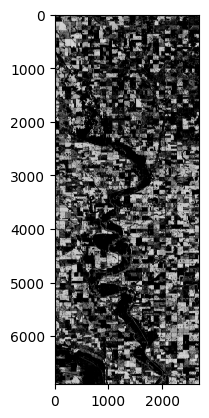

In [130]:
## Prepare Label. This shows cropland. 
# See how much change happened before and after ... 
change = before_ndvi - after_ndvi
# Only use change from before to After.
change[change<=0] = 0
change = ( change - change.min() ) / (change.max() - change.min())

plt.imshow(change, cmap='gray')

In [145]:
TILE_SIZE = 256
# Assuming your original array is named `array` with shape (N, 1443, 1499)
_, H, W = before.shape

# Calculate the number of tiles that fit in each dimension
num_tiles_y = H // TILE_SIZE  # Number of tiles along the height
num_tiles_x = W // TILE_SIZE  # Number of tiles along the width

print(num_tiles_x, num_tiles_y)

# Initialize a list to store the tiles
tiles_before = []
tiles_after = []
tiles_changes = []

row_col_info = [] # To get back corresponding RGB images for plot from before_rgb, after_rgb
# Loop through the height and width to extract each tile
for i in range(num_tiles_y):
    for j in range(num_tiles_x):
        row_start, row_end = i * TILE_SIZE, (i+1) * TILE_SIZE
        col_start, col_end = j * TILE_SIZE, (j+1) * TILE_SIZE

        row_col_info.append( [row_start, row_end, col_start, col_end] )
        # Extract the tile
        tile_before = before[:, row_start:row_end, col_start:col_end ]
        tile_after = after[ :, row_start:row_end, col_start:col_end ]
        tile_change = change[ row_start:row_end, col_start:col_end ]
        tiles_before.append(tile_before)
        tiles_after.append(tile_after)
        tiles_changes.append(tile_change)

# Convert list of tiles to numpy array
tiles_before = np.array(tiles_before)
tiles_after = np.array(tiles_after)
tiles_changes = np.array(tiles_changes)


print(tiles_before.shape)  # Expected shape: (num_tiles_y * num_tiles_x, N, 256, 256)

tiles_all = np.concatenate( (tiles_before, tiles_after) , axis=0)
tiles_changes_all = np.concatenate( (tiles_changes, tiles_changes) , axis=0)
row_col_info_all = np.concatenate( ( row_col_info, row_col_info ), axis=0)


import pickle

indices_path = "data_indices.pkl"
if os.path.exists(indices_path):
    print("Loading INdices")
    with open( indices_path , 'rb') as f:
        indices = pickle.load(f)

else:
    print("Dumping Indices")
    with open( indices_path, 'wb') as f:
        indices = list(np.random.permutation(tiles_all.shape[0]))
        pickle.dump(indices, f)

row_col_info_all = np.array(row_col_info_all)[indices]
tiles_all = tiles_all[indices]
tiles_changes_all = tiles_changes_all[indices]
print(tiles_before.shape)  # Expected shape: (num_tiles_y * num_tiles_x, N, 256, 256)

10 26
(260, 27, 256, 256)
Loading INdices
(260, 27, 256, 256)


In [146]:
TRAIN_PCT = 0.7
TRAIN_IDX = int(len(tiles_before) * TRAIN_PCT)


In [170]:
def per_channel_normalize(x):
    '''
    x : numpy array of shape (channel, height, width)
    ## USED TO NORMALIZE INPUT CHANNEL
    '''
    out = (x.T - x.min((1,2))) / (x.max((1,2)) - x.min((1,2)))
    return out.transpose(2,1,0)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
CHANNELS_INDEXES = [4,3,2,7] ## channels to use in modeling
BATCH_SIZE = 16

NUM_CHANNELS = len(CHANNELS_INDEXES)

In [186]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.middle = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, out_channels, kernel_size=1),
            nn.Sigmoid()  # Final sigmoid activation

        )
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        x1 = self.encoder(x)
        # print(x1.shape)
        x2 = self.middle(x1)
        # print(x2.shape)
        x3 = self.up(x2)
        # print(x3.shape)
        x4 = self.decoder(x3)
        # print(x4.shape)
        
        return x4

In [195]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)

        # Middle
        self.middle = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # Decoder
        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),  # Concatenation doubles channels
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),  # Concatenation doubles channels
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # Final output layer
        self.final = nn.Sequential(
            nn.Conv2d(64, out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encoder
        # import pdb; pdb.set_trace()
        x1 = self.enc1(x)  # 64 channels
        x2 = self.pool1(x1)  # Downsample

        x3 = self.enc2(x2)  # 128 channels
        x4 = self.pool2(x3)  # Downsample

        # Middle
        x5 = self.middle(x4)  # 256 channels

        # Decoder
        x6 = self.up1(x5)  # Upsample to match x3
        x6 = torch.cat([x6, x3], dim=1)  # Concatenate encoder feature map
        x7 = self.dec1(x6)  # 128 channels

        x8 = self.up2(x7)  # Upsample to match x1
        x8 = torch.cat([x8, x1], dim=1)  # Concatenate encoder feature map
        x9 = self.dec2(x8)  # 64 channels

        # Final output
        output = self.final(x9)  # 1 output channel (probability map)
        return output

In [196]:
from torchsummary import summary

in_channels = NUM_CHANNELS  # Number of channels in X
out_channels = 1  # Single-channel output for probability map
model = UNet(in_channels, out_channels)
# model.to(device)

In [197]:
summary(model, (4,256,256) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           2,368
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [179]:
indices[-10:]

[289, 174, 85, 494, 357, 351, 128, 340, 7, 374]

In [187]:
import torch

# before_preds = []
# after_preds = []

for model_path in [
    # './unet_combined_loss_30_epochs/best_model.pth',
    # './unet_bce_loss_30_epochs/best_model.pth',
    # './unet_dice_loss_30_epochs/best_model.pth',
    './baseline_dice_loss_30_epochs/best_model.pth'
]:
    # Create an instance of the U-Net
    in_channels = NUM_CHANNELS  # Number of channels in X
    out_channels = 1  # Single-channel output for probability map
    model = UNet(in_channels, out_channels)
    model.to(device)
    # 2. Load the saved state dictionary
    model.load_state_dict(torch.load( model_path ))

    # 3. Set the model to eval mode (if you are making predictions)
    out = model.eval() 

    IDX = 174
    r_s, r_e, c_s, c_e = row_col_info_all[IDX]
    ## Before 
    X_orig = before[CHANNELS_INDEXES , r_s:r_e, c_s:c_e]
    X = per_channel_normalize(X_orig)
    X = torch.Tensor( X ).float().to(device)

    X_orig_after = after[CHANNELS_INDEXES , r_s:r_e, c_s:c_e]
    X_after = per_channel_normalize(X_orig_after)
    X_after = torch.Tensor( X_after ).float().to(device)

    with torch.no_grad():  
        test_output = model(torch.unsqueeze(X,dim=0))
        test_output_after = model(torch.unsqueeze(X_after,dim=0))        

    before_preds.append(
        test_output[0][0].to("cpu").clone()
    )
    
    after_preds.append(
        test_output_after[0][0].to("cpu").clone()
    )

/var/folders/5q/d5sngbr11bj5s27jzhrdww2r0000gn/T/ipykernel_61625/1827255376.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load( model_path

In [181]:
# x_image = X.permute((1,2,0)) # First example of test-batch
pred_croparea = tiles_changes_all[IDX]

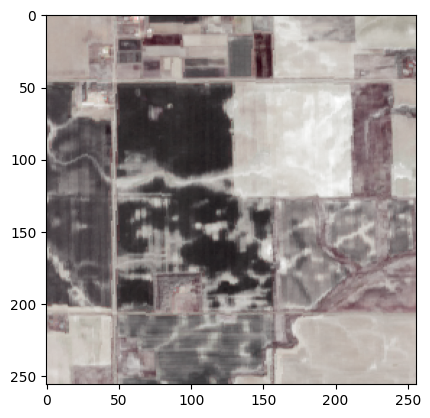

In [182]:
plt.imshow(x_image.to("cpu"))

/var/folders/5q/d5sngbr11bj5s27jzhrdww2r0000gn/T/ipykernel_61625/3278403492.py:43: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


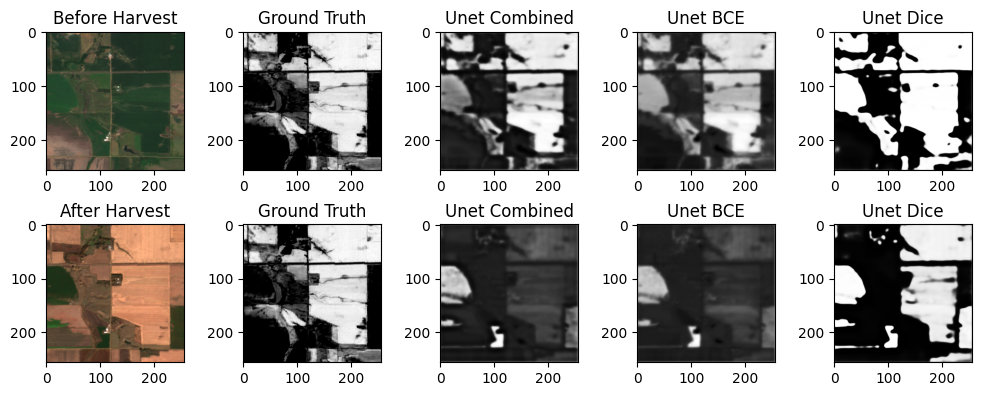

In [183]:
# Function to plot input image and prediction side by side
# fig, ax = plt.subplots(2, 3, figsize=(8, 8))

fig, ax = plt.subplots(2, 5, figsize=(10, 4), constrained_layout=True)  # Adjusted figsize and added constrained_layout


# Plot the input image
# ax[0,0].axis('off')
# Plot ACTUAL RGB



ax[0,0].imshow(before_rgb[ r_s:r_e, c_s: c_e, :  ] )
ax[0,0].set_title("Before Harvest")

ax[0,1].imshow( pred_croparea, cmap="gray")  
ax[0,1].set_title("Ground Truth")

ax[0,2].imshow( before_preds[0] , cmap="gray")  
ax[0,2].set_title("Unet Combined")

ax[0,3].imshow( before_preds[1] , cmap="gray")  
ax[0,3].set_title("Unet BCE")

ax[0,4].imshow( before_preds[2] , cmap="gray")  
ax[0,4].set_title("Unet Dice")

ax[1,0].imshow(after_rgb[ r_s:r_e, c_s: c_e, :  ] )
ax[1,0].set_title("After Harvest")

ax[1,1].imshow( pred_croparea, cmap="gray")  
ax[1,1].set_title("Ground Truth")

ax[1,2].imshow( after_preds[0] , cmap="gray")  
ax[1,2].set_title("Unet Combined")

ax[1,3].imshow( after_preds[1] , cmap="gray")  
ax[1,3].set_title("Unet BCE")

ax[1,4].imshow( after_preds[2] , cmap="gray")  
ax[1,4].set_title("Unet Dice")

plt.tight_layout()
plt.show()


/var/folders/5q/d5sngbr11bj5s27jzhrdww2r0000gn/T/ipykernel_61625/4169761364.py:49: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


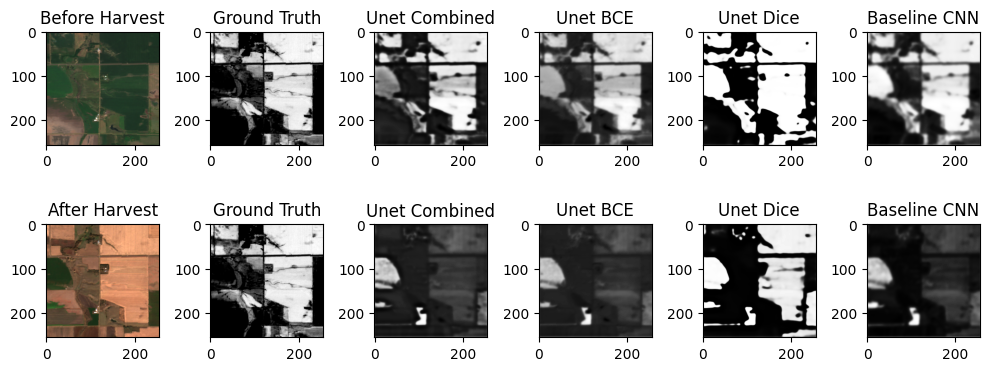

In [189]:
# Function to plot input image and prediction side by side
# fig, ax = plt.subplots(2, 3, figsize=(8, 8))

fig, ax = plt.subplots(2, 6, figsize=(10, 4), constrained_layout=True)  # Adjusted figsize and added constrained_layout


# Plot the input image
# ax[0,0].axis('off')
# Plot ACTUAL RGB



ax[0,0].imshow(before_rgb[ r_s:r_e, c_s: c_e, :  ] )
ax[0,0].set_title("Before Harvest")

ax[0,1].imshow( pred_croparea, cmap="gray")  
ax[0,1].set_title("Ground Truth")

ax[0,2].imshow( before_preds[0] , cmap="gray")  
ax[0,2].set_title("Unet Combined")

ax[0,3].imshow( before_preds[1] , cmap="gray")  
ax[0,3].set_title("Unet BCE")

ax[0,4].imshow( before_preds[2] , cmap="gray")  
ax[0,4].set_title("Unet Dice")

ax[0,5].imshow( before_preds[3] , cmap="gray")  
ax[0,5].set_title("Baseline CNN")

ax[1,0].imshow(after_rgb[ r_s:r_e, c_s: c_e, :  ] )
ax[1,0].set_title("After Harvest")

ax[1,1].imshow( pred_croparea, cmap="gray")  
ax[1,1].set_title("Ground Truth")

ax[1,2].imshow( after_preds[0] , cmap="gray")  
ax[1,2].set_title("Unet Combined")

ax[1,3].imshow( after_preds[1] , cmap="gray")  
ax[1,3].set_title("Unet BCE")

ax[1,4].imshow( after_preds[2] , cmap="gray")  
ax[1,4].set_title("Unet Dice")

ax[1,5].imshow( after_preds[3] , cmap="gray")  
ax[1,5].set_title("Baseline CNN")

plt.tight_layout()
plt.show()


## Comparison Plot
- Plot VAL IOU SCORES FOR ALL MODELS
- PLOT VAL DICE SCORES for all Models

In [73]:
import json

In [119]:
baseline_losses_pth = "./baseline_dice_loss_30_epochs/losses.json"
with open(baseline_losses_pth, 'r') as f:
    baseline_losses = json.load(f)


unet_combined_losses_pth = "./unet_combined_loss_30_epochs/losses.json"
with open(unet_combined_losses_pth, 'r') as f:
    unet_combined_losses = json.load(f)


unet_dice_losses_pth = "./unet_dice_loss_30_epochs/losses.json"
with open(unet_dice_losses_pth, 'r') as f:
    unet_dice_losses = json.load(f)

unet_dice_losses_hard_pth = "./unet_dice_loss_30_epochs/losses.json"
with open(unet_dice_losses_hard_pth, 'r') as f:
    unet_dice_hard_losses = json.load(f)

unet_bce_losses_pth = "./unet_bce_loss_30_epochs/losses.json"
with open(unet_bce_losses_pth, 'r') as f:
    unet_bce_losses = json.load(f)


In [ ]:
unet_combined_dice_train_loss = unet_combined_losses['train_dice_losses']
unet_combined_dice_val_loss = unet_combined_losses['val_dice_losses']
unet_combined_iou_val = unet_combined_losses['val_iou_scores']

unet_combined_iou_train = unet_combined_losses['train_iou_scores']


unet_bce_dice_train_loss = unet_bce_losses['train_dice_losses']
unet_bce_dice_val_loss = unet_bce_losses['val_dice_losses']
unet_bce_iou_val = unet_bce_losses['val_iou_scores']

unet_dice_dice_train_loss = unet_dice_losses['train_dice_losses']
unet_dice_dice_val_loss = unet_dice_losses['val_dice_losses']
unet_dice_iou_val = unet_dice_losses['val_iou_scores']

unet_dice_hard_dice_train_loss = unet_dice_hard_losses['train_dice_losses']
unet_dice_hard_dice_val_loss = unet_dice_hard_losses['val_dice_losses']
unet_dice_hard_iou_val = unet_dice_hard_losses['val_iou_scores']


baseline_dice_train_loss = baseline_losses['train_dice_losses']
baseline_dice_val_loss = baseline_losses['val_dice_losses']
baseline_iou_val = baseline_losses['val_iou_scores']




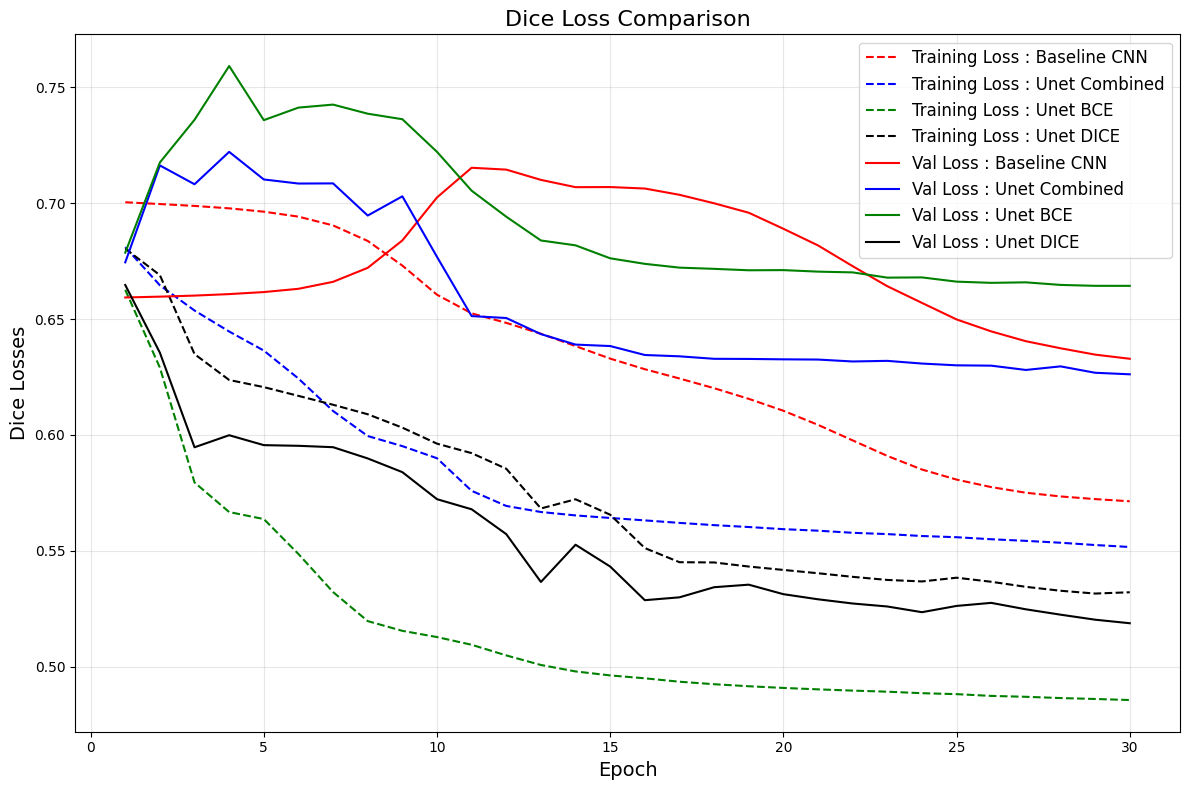

In [124]:
# Plotting
num_epochs = 30
epochs = list(range(1, num_epochs + 1))
plt.figure(figsize=(12, 8))

# compare Training Dice loss
plt.plot( list(range(1, len(baseline_dice_train_loss)+ 1)) , baseline_dice_train_loss, label="Training Loss : Baseline CNN", color="red", linestyle="--")
plt.plot( list(range(1, len(unet_combined_dice_train_loss)+ 1)) , unet_combined_dice_train_loss, label="Training Loss : Unet Combined", color="blue", linestyle="--")
plt.plot( list(range(1, len(unet_bce_dice_train_loss)+ 1)) , unet_bce_dice_train_loss, label="Training Loss : Unet BCE", color="green", linestyle="--")
plt.plot( list(range(1, len(unet_dice_dice_train_loss)+ 1)) , unet_dice_dice_train_loss, label="Training Loss : Unet DICE", color="black", linestyle="--")
# plt.plot( list(range(1, len(unet_dice_hard_dice_train_loss)+ 1)) , unet_dice_hard_dice_train_loss, label="Training Loss : Unet DICE Hard", color="orange", linestyle="--")




# compare Validation Dice loss
plt.plot( list(range(1, len(baseline_dice_val_loss)+ 1)) , baseline_dice_val_loss, label="Val Loss : Baseline CNN", color="red", linestyle="-")
plt.plot( list(range(1, len(unet_combined_dice_val_loss)+ 1)) , unet_combined_dice_val_loss, label="Val Loss : Unet Combined", color="blue", linestyle="-")
plt.plot( list(range(1, len(unet_bce_dice_val_loss)+ 1)) , unet_bce_dice_val_loss, label="Val Loss : Unet BCE", color="green", linestyle="-")
plt.plot( list(range(1, len(unet_dice_dice_val_loss)+ 1)) , unet_dice_dice_val_loss, label="Val Loss : Unet DICE", color="black", linestyle="-")
# plt.plot( list(range(1, len(unet_dice_hard_dice_val_loss)+ 1)) , unet_dice_hard_dice_val_loss, label="Val Loss : Unet DICE Hard", color="orange", linestyle="-")



# compare IOU score
# plt.plot( list(range(1, len(unet_combined_iou_val)+ 1)) , unet_combined_iou_val, label="IOU : Unet Combined", color="blue", linestyle="-")
# plt.plot( list(range(1, len(baseline_iou_val)+ 1)) , baseline_iou_val, label="IOU : Baseline Model", color="red", linestyle="-")


# Adding labels, legend, and grid
plt.title("Dice Loss Comparison", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Dice Losses", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()

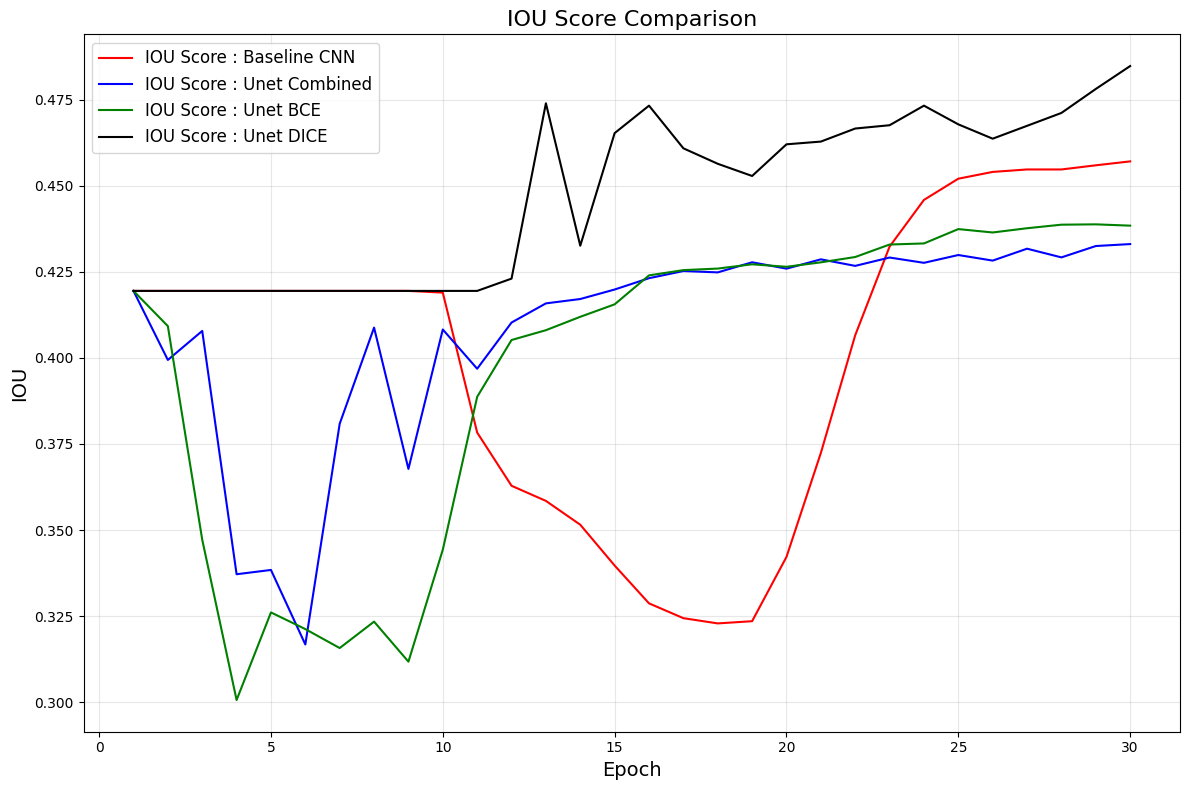

In [ ]:
# Plotting
num_epochs = 30
epochs = list(range(1, num_epochs + 1))
plt.figure(figsize=(12, 8))

# compare Training Dice loss
plt.plot( list(range(1, len(baseline_iou_val)+ 1)) , baseline_iou_val, label="Training IOU Score : Baseline CNN", color="red", linestyle="-")
plt.plot( list(range(1, len(unet_combined_iou_val)+ 1)) , unet_combined_iou_val, label="Training IOU Score : Unet Combined", color="blue", linestyle="-")
plt.plot( list(range(1, len(unet_bce_iou_val)+ 1)) , unet_bce_iou_val, label="Training IOU Score : Unet BCE", color="green", linestyle="-")
plt.plot( list(range(1, len(unet_dice_iou_val)+ 1)) , unet_dice_iou_val, label="Training IOU Score : Unet DICE", color="black", linestyle="-")


plt.plot( list(range(1, len(baseline_iou_val)+ 1)) , baseline_iou_val, label="Val IOU Score : Baseline CNN", color="red", linestyle="--")
plt.plot( list(range(1, len(unet_combined_iou_val)+ 1)) , unet_combined_iou_val, label="Val IOU Score : Unet Combined", color="blue", linestyle="--")
plt.plot( list(range(1, len(unet_bce_iou_val)+ 1)) , unet_bce_iou_val, label="Val IOU Score : Unet BCE", color="green", linestyle="--")
plt.plot( list(range(1, len(unet_dice_iou_val)+ 1)) , unet_dice_iou_val, label="Val IOU Score : Unet DICE", color="black", linestyle="--")
# plt.plot( list(range(1, len(unet_dice_hard_iou_val)+ 1)) , unet_dice_hard_iou_val, label="IOU Score : Unet DICE Hard", color="orange", linestyle="-")


# Adding labels, legend, and grid
plt.title("IOU Score Comparison", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("IOU", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()

In [2]:
import numpy as np

In [3]:
def soft(x,t):
    _sum = np.sum( np.exp( x/t ))
    return np.exp(x/t) / _sum

In [5]:
soft( np.array( [ 1,2,3 ] ), t=1)

array([0.09003057, 0.24472847, 0.66524096])

In [7]:
soft( np.array( [ 1,2,3 ] ), t=0.01)

array([1.38389653e-87, 3.72007598e-44, 1.00000000e+00])

In [10]:
soft( np.array( [ 1,2,5 ] ), t=1)

array([0.01714783, 0.04661262, 0.93623955])